In [42]:
import statsmodels as sm
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# OLS with Seasonality Decompose

Cómo hemos visto en el módulo, las series temporales siempre "esconden" información adicional que podemos incorporar a nuestros modelos. En este ejercicio, vamos a tomar un ejemplo básico de series temporales basado en las ventas de un producto para la tos. El dataset es muy simple, tiene las ventas (sales), un covid_flag que marca los meses en donde hubo mayor impacto de la pandemia (ya que tiene un alto impacto en las ventas siempre se debe considerar) y el flu_index, que es basicamente una métrica de qué porcentaje de la población tiene síntomas asociados a la gripe. 

Vamos a utilizar nuestros conocimientos de ML para crear un modelo de series temporales. 

In [6]:
data = pd.read_csv("../../DATA/time_series_data.csv")  # Cargamos datos
data['ds'] = pd.to_datetime(data['ds'])  # la cambiamos a formato fecha
data.dropna(inplace=True)
data.set_index('ds', inplace=True) # Para facilidad, utilizamos ds como ínidice.
data.head()


,sales,covid_flag,flu_index
ds,,,
2018-09-17 00:00:00+00:00,75982.11870,0,7
2018-09-24 00:00:00+00:00,88005.37465,0,11
2018-10-01 00:00:00+00:00,101737.73724,0,14
2018-10-08 00:00:00+00:00,98258.54988,0,7
2018-10-15 00:00:00+00:00,94549.62839,0,13


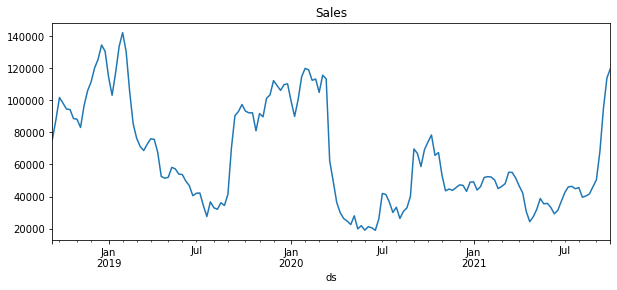

In [32]:
# Simple exploración de los datos
data.sales.plot(
    figsize=(10, 4),
    title='Sales'

)
plt.show()

Podemos ver en Marzo de 2020 el impacto de la Pandemia en las ventas, ya que están caen velozmente debido a que la gente se encierra en sus casas, y luego, al haber menos gente en lugares públicos, la cantidad de enfermedades infecciosas (aparte del COVID) se reducen significativamente.

# Extracción de Seasonality y Trend.

Las series temporales "esconden" información relevante sobre su comportamiento a través de temporalidades (está claro que las ventas incrementan en los meses de invierno) y la tendencia de la serie (es notable la tendencia a la baja en las ventas, incluso antes de la pandemia).

In [7]:
#Attention here, see if trend is linear, how it is extracted, etc !!!
sales_ts = data.sales.copy()
to_decompose = sales_ts.asfreq('W-MON')
decomp_data = seasonal_decompose(
    to_decompose, model='additive',
    extrapolate_trend=True
)

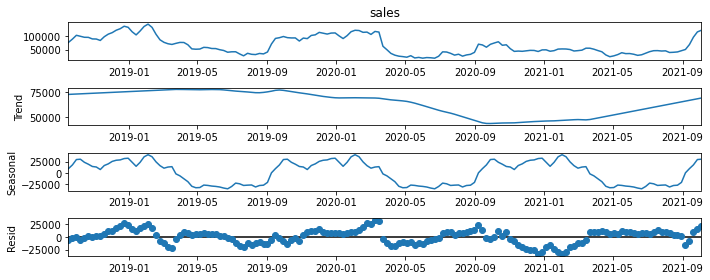

In [17]:
fig = decomp_data.plot()
fig.set_size_inches((10, 4))
# Tight layout para mejorar la viz
fig.tight_layout()
plt.show()  # Graficamos Trend, seasonality

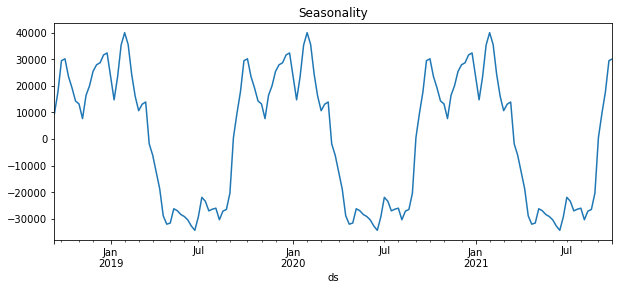

In [24]:
# Enfoque en la seasonality
fig = decomp_data.seasonal.plot(
    figsize=(10,4),
    title='Seasonality'
)
plt.show()  # Graficamos Trend, seasonality

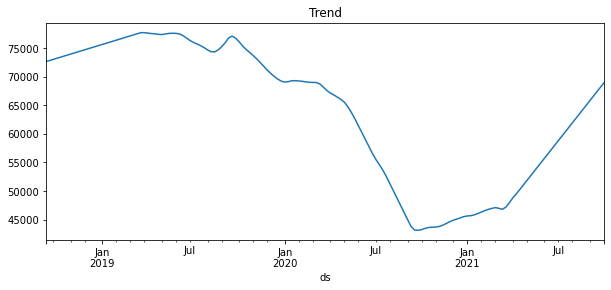

In [33]:
# Enfoque en la Trend
fig = decomp_data.trend.plot(
    figsize=(10,4),
    title='Trend'
)
plt.show()  # Graficamos Trend, seasonality

En efecto, hemos capturado la temporalidad de nuestra serie, además de la tendencia que habíamos notado con una simple exploración visual

In [55]:
# Agregamos la nueva columna de sesonality 
target_col = 'sales'
# Añadimos trend y seasonality
data['trend'] = decomp_data.trend.values
data['seasonality'] = decomp_data.seasonal.values

# Seperamos entre test y train por un eje temporal. 

TRAIN_TEST_RATIO = 0.25  # % de datos que iran al test

cut = int(len(data) * (1 - TRAIN_TEST_RATIO))

train = data.iloc[ : cut]
test = data.iloc[cut : ]
# Añadimos una constante ya que son relevantes para calcular 
# el intercept en los modelos lineales
train = sm.tools.add_constant(train)
test =  sm.tools.add_constant(test)


# Separación entre variables dependientes e independiente
X_train = train.loc[:, train.columns != target_col] 
y_train = train[target_col]
X_test = test.loc[:, test.columns != target_col] 
y_test = test[target_col]

# ENTRENAMOS EL MODELO
model = OLS(y_train, X_train)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     220.4
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           6.23e-53
Time:                        17:53:19   Log-Likelihood:                -1290.3
No. Observations:                 120   AIC:                             2591.
Df Residuals:                     115   BIC:                             2605.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.002e+04   1.66e+04      3.016      

/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


R Squared: 0.44


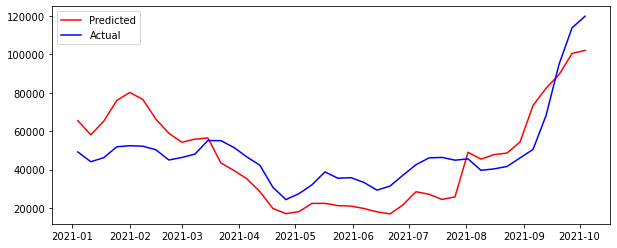

In [56]:
# Comprobamos que los resultados se mantengan en el set de test

pred = results.predict(X_test)

print(f'R Squared: {round(r2_score(y_test, pred) , 2)}')

f = plt.figure(figsize=(10,4))
plt.plot(pred, c='r', label='Predicted')
plt.plot(y_test, c='b', label='Actual')
plt.legend()
plt.show()

Nuestro modelo tiene un poder predictivo decente, sin embargo se podría mejorar probando diferentes formas de calcular la tendencia, añadiendo diferentes variables al modelo y probando otro tipo de algoritmos. También hemos visto que el poder predictivo es menor en el set de entrenamiento. Esto posiblemente nos indique que existe algo de overfitting en el modelo. Este problema suele ser bastante más común en problemas de predicción de series temporales que en otro tipo de modelos de ML. 

# FB Prophet 

Prophet es un procedimiento de predicción de datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos que faltan y a los cambios de tendencia, y suele manejar bien los valores atípicos (outliers).

Prophet es un software de código abierto publicado por el equipo de Ciencia de Datos de Facebook.

Es mundialmente reconocido por ser fácil de usar, veloz y tener un buen desempeño en predicción de series temporales-

Tiene una excelente documentación y una gran cantidad de tutoriales que pueden verse en el siguiente
[LINK](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Aquí se reproduce el tutorial básico, sin embargo, sería interesante que apliques el algoritmo de Prophet en el dataset anterior. ¿Qué resultados se obtienen? 

NOTA: Instalarlo en Windows puede ser algo complicado, por lo que recomiendo ver este link si ese es el sistema operativo que estás utilizando

https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10

In [58]:
from fbprophet import Prophet


In [57]:
# Ejemplo básico Pases de Peyton Manning
df = pd.read_csv(
    'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
)
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [59]:
# Muy sencillo, simplemente llamamos al fit y listo 
# Recuerda que prophet necesita que las columnas se llamen "ds" y "y"
m = Prophet()
m.fit(df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.4685


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7976.66    0.00444357       453.026           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       7991.33   3.47837e-05       114.938   3.253e-07       0.001      269  LS failed, Hessian reset 
     199       7992.36   0.000526128       162.677           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       7998.14   4.23891e-05       142.064   2.782e-07       0.001      436  LS failed, Hessian reset 
     299       7998.58   0.000381087       163.741      0.2361           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8001.14   3.07041e-05       62.7479           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha

In [60]:
# Iniciamos un dataset que tendrá  nuestras predicciones a futuro
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [61]:
# Realizamos el forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.204617,7.444539,8.972428
3266,2017-01-16,8.529628,7.826641,9.227787
3267,2017-01-17,8.317021,7.570155,8.994976
3268,2017-01-18,8.149634,7.390032,8.833772
3269,2017-01-19,8.161561,7.422920,8.951669


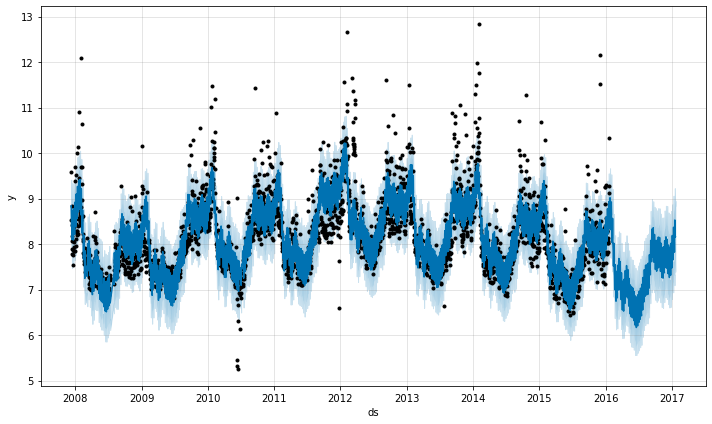

In [62]:
# Prophet tiene incorporado un excelente módulo de plotting
# Puntos negros son los reales, linea azul la predicción
fig1 = m.plot(forecast)


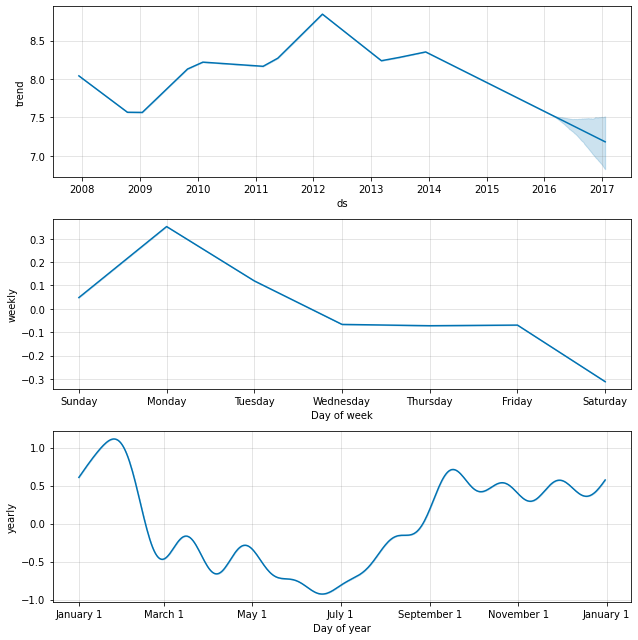

In [63]:
# Ploteamos componentes como Trend y Seasonality
fig2 = m.plot_components(forecast)


In [64]:
import plotly 

# Si tienes plotly instalado, incluso puedes realizar plots interactivos!
# Para instalar plotly simplemente utiliza pip install plotly
from fbprophet.plot import plot_plotly

plot_plotly(m, forecast)
